In [2]:
#Important Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

#Data Encoding
from sklearn.preprocessing import  OneHotEncoder

#Preprocessing
from sklearn.preprocessing import StandardScaler

#To handle imbalanced data
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

#Classifier
from sklearn.ensemble import IsolationForest

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [9]:
#Synthetic dataset
synth_train = pd.read_csv('/content/drive/MyDrive/Degree Project/train.zip', delimiter=',')
synth_test = pd.read_csv('/content/drive/MyDrive/Degree Project/test.zip', delimiter=',')
def data(df):
  Y = df['Label']                                  #Labels
  Y = Y.to_numpy()
  X = df.to_numpy()
  X = np.delete(X, -1, axis=1)
  X1 = X[:,0:2]                                    #Categorical Features
  X2 = X[:, 2:]                                    #Numerical Features
  min_val = np.min(X2,axis=0)
  max_val = np.max(X2,axis=0)
  X2 = (X2 - min_val) / (max_val - min_val)
  X1 = OneHotEncoder().fit_transform(X1).toarray() #Encode categorical features
  X = np.concatenate((X1,X2), axis=1)
  X = np.asarray(X).astype('float32')
  Y = np.asarray(Y).astype('float32')
  X = StandardScaler().fit_transform(X)           #Standardizes data
  return X,Y

X_train, Y_train = data(synth_train)
X_test, Y_test = data(synth_test)

In [3]:
#KDD-Cup 99 dataset
KDD_train = pd.read_csv('/content/drive/MyDrive/Degree Project/kddcup.data_10_percent.gz', compression='gzip').dropna() 
KDD_test = pd.read_csv('/content/drive/MyDrive/Degree Project/corrected.gz', compression='gzip').dropna()
KDD_train.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome'
]

KDD_test.columns = KDD_train.columns
#Remove duplicates
KDD_train = KDD_train.drop_duplicates(keep=False)
KDD_test = KDD_test.drop_duplicates(keep=False)
#Change outcome to 0 if normal and 1 if anomalous
KDD_train['outcome'] = (KDD_train['outcome']!='normal.')*1
KDD_test['outcome'] = (KDD_test['outcome']!='normal.')*1
def data(df):
  X = df.to_numpy()
  Y = X[:,-1]
  X = np.delete(X, -1, axis=1)
  X1 = np.array([X[:,0]]).transpose()
  X2 = OneHotEncoder().fit_transform(X[:,1:2]).toarray()
  X3 = X[:,4:]
  X = np.concatenate((X1,X2,X3), axis=1)
  X = np.asarray(X).astype('float32')
  Y = np.asarray(Y).astype('float32')
  # min_val = np.min(X2)
  # max_val = np.max(X2)
  # X = (X - min_val) / (max_val - min_val)
  X = StandardScaler().fit_transform(X)
  normal_indx = np.where(Y==0)                      #Index of normal observations
  anomaly_indx = np.where(Y==1)                     #Index of anomalies
  X_normal  = X[normal_indx]
  X_anomaly = X[anomaly_indx]
  Y_normal  = Y[normal_indx]
  Y_anomaly = Y[anomaly_indx]
  return X,X_normal,X_anomaly,Y,Y_normal,Y_anomaly

X_train,X_normal_train,X_anomaly_train,Y_train,Y_normal_train,Y_anomaly_train = data(KDD_train)
X_test,X_normal_test,X_anomaly_test,Y_test,Y_normal_test,Y_anomaly_test       = data(KDD_test) 

In [10]:
#Isolation Forest
iForest = IsolationForest(n_estimators=300, bootstrap=True, max_samples=0.05, n_jobs=-1)
iForest.fit(X_train)
scores = iForest.score_samples(X_test)

In [5]:
#Evaluate scores
def evaluate(Y_real, scores, Dataset='Synthetic'): #Dataset is 
  #Distribution of scores
  plt.figure()
  plt.hist(scores, bins=50)
  plt.xlabel("Anomaly score")
  plt.ylabel("No of examples")
  plt.title('Distribution of anomaly scores')
  plt.show()
  #PPrecision-Recall curve
  precision, recall, thresholds = precision_recall_curve(Y_real, scores)
  auc_precision_recall = auc(recall, precision)
  indx = np.where(precision==0.)
  precision = np.delete(precision,indx)
  recall = np.delete(recall,indx)
  thresholds = np.delete(thresholds,indx)
  plt.figure()
  plt.plot(recall,precision)
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title(Dataset+' datset')
  plt.show()
  #Performance Scores
  F1_scores      = 2*precision*recall/(precision+recall)
  F1_max         = np.max(F1_scores)
  threshold_indx = np.where(F1_scores==F1_max) 
  y_pred = scores>=thresholds[threshold_indx]
  CM = confusion_matrix(Y_test,y_pred)

  TNR = CM[0,0] #True negative rate
  TPR = CM[1,1] #True positive rate
  FNR = CM[0,1] #False negative rate
  FPR = CM[1,0] #False positive rate

  #Table of performance metrics
  data = {'AUC_precision_recall': [auc_precision_recall], 'F1': [F1_max], 'TNR': [TNR], 'TPR': [TPR], 'FNR': [FNR], 'FPR': [FPR]}
  performance = pd.DataFrame(data, columns=['AUC_precision_recall', 'F1', 'TNR', 'TPR', 'FNR', 'FPR'], index=[Dataset])
  display(performance)
  return performance

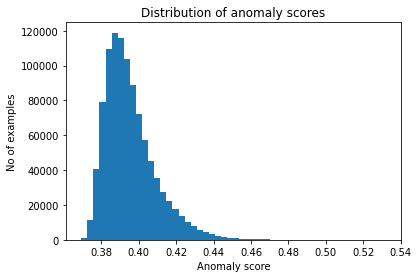

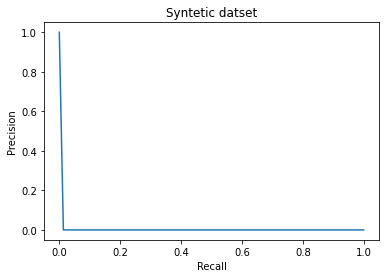

,AUC_precision_recall,F1,TNR,TPR,FNR,FPR
Syntetic,0.000113,0.007168,999797,1,203,74


In [11]:
scores = -scores
table = evaluate(Y_test, scores, Dataset='Syntetic')

In [12]:
print(table.to_latex(index=True, multirow=True))

\begin{tabular}{lrrrrrr}
\toprule
{} &  AUC\_precision\_recall &        F1 &     TNR &  TPR &  FNR &  FPR \\
\midrule
Syntetic &              0.000113 &  0.007168 &  999797 &    1 &  203 &   74 \\
\bottomrule
\end{tabular}

